## Imports

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer
from src.analysis.graph_community_analyzer_graph_tool import GraphCommunityAnalyzerGraphTool

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from graph_tool.all import load_graph, GraphView, graph_draw, prop_to_size, closeness, eigenvector
from graph_tool import openmp_set_num_threads


(ipykernel_launcher.py:2492): dbind-WARNING **: 08:09:53.546: AT-SPI: Error retrieving accessibility bus address: org.freedesktop.DBus.Error.ServiceUnknown: The name org.a11y.Bus was not provided by any .service files


In [ ]:
from src.analysis.utils import get_node_ids_from_community, plot_stats_for_category_quarterly

from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db

db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)


Database initialized: wikipedia.db


## Initialize Graphs

In [3]:
openmp_set_num_threads(8)

# 'Artificial intelligence' not yet done
graph_names = ['Amiga_CD32_games', 'Machine_learning','Game_Boy_games']

graphs = [{"graph_name": graph_name, "graph": load_graph('outputs/graphs/{}.gt'.format(graph_name))} for graph_name in graph_names]


In [4]:
for graph_instance in graphs:
    print(f"-------------Graph: {graph_instance['graph_name']}-------------")
    num_nodes = graph_instance['graph'].num_vertices()
    num_edges = graph_instance['graph'].num_edges()

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")


-------------Graph: Amiga_CD32_games-------------
Number of nodes: 8013
Number of edges: 1537410
-------------Graph: Machine_learning-------------
Number of nodes: 75217
Number of edges: 26149964
-------------Graph: Game_Boy_games-------------
Number of nodes: 8953
Number of edges: 4095265


## Community detection

In [5]:
graph_comm = graphs[1]['graph']
graph_name = graphs[1]['graph_name']

graph_community_analyzer = GraphCommunityAnalyzerGraphTool(graph_comm, 'outputs/graphs/{}_communities'.format(graph_name))
# graph_community_analyzer.calc_minimize_blockmodel_dl(output_plot=False)

Graph: 75217 vertices, 26149964 edges
Randomized Graph: 75217 vertices, 26149964 edges


In [6]:
mod_state = graph_community_analyzer.calc_modularity_maximization(output_plot=False,niter=4000)
# mod_state_random = graph_community_analyzer.calc_modularity_maximization(output_plot=False, niter=2000, is_random=True)

Number of blocks: 267


### Get community vertex property

In [7]:
# print(f"communities {graph_community_analyzer.communities}")
property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()
# property_map_communities_random = graph_community_analyzer.communities['communities_modularity_random'].get_array()


### Plot community sizes

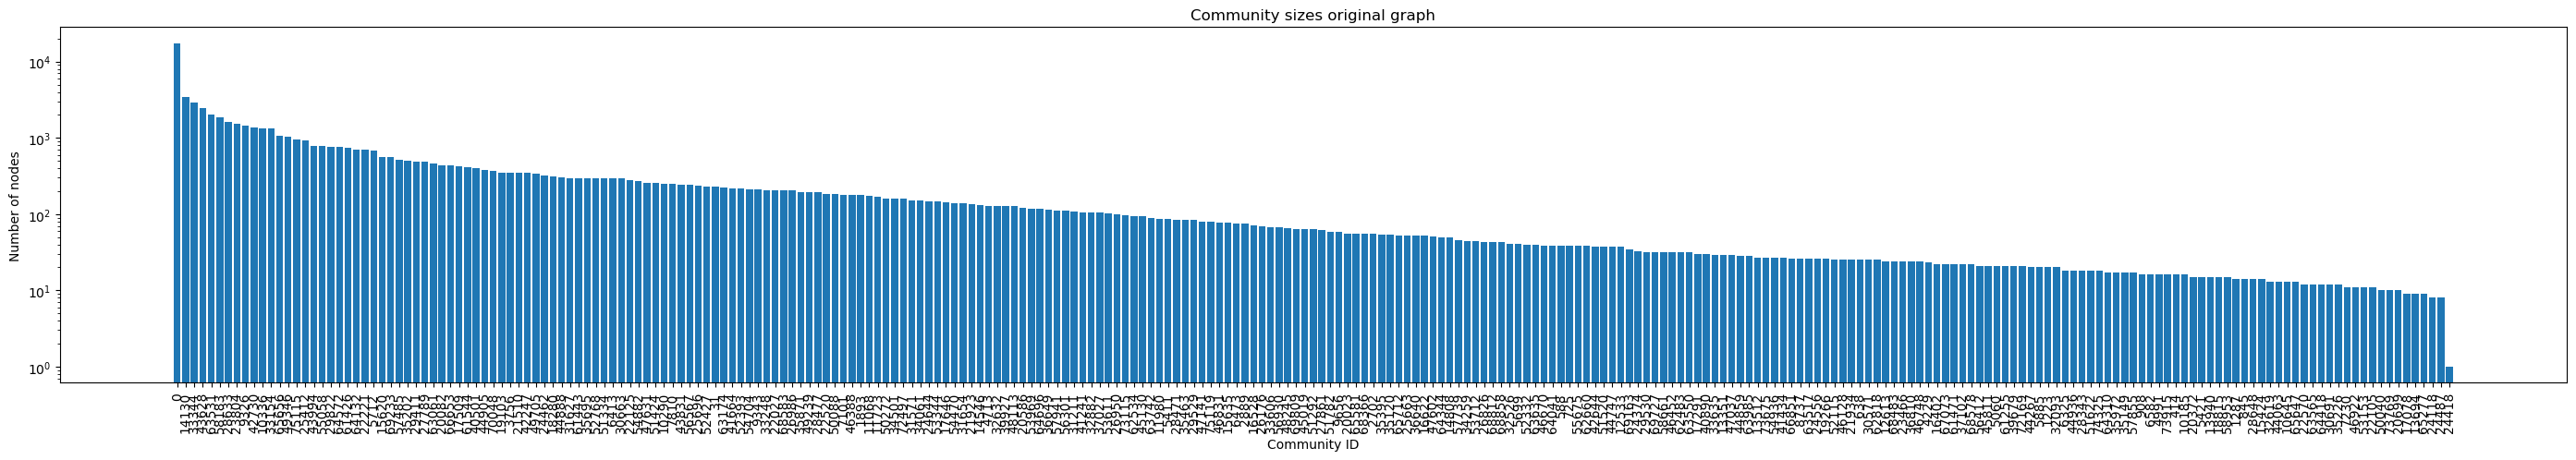

In [43]:
#plot community sizes

community_counts = Counter(property_map_communities)
# community_counts_random = Counter(property_map_communities_random)

sorted_list_of_community_ids_by_size = sorted(community_counts, key=community_counts.get, reverse=True)
# sorted_list_of_community_ids_by_size_random = sorted(community_counts_random, key=community_counts_random.get, reverse=True)



fig, ax = plt.subplots(1, 1, figsize=(35, 5))

sorted_community_counts = {community: community_counts[community] for community in sorted_list_of_community_ids_by_size}

x_label_strings = [f'{community}' for community in sorted_community_counts.keys()]
x = np.arange(len(sorted_community_counts.keys()))
ax.bar(x, sorted_community_counts.values())
ax.set_title('Community sizes original graph')
ax.set_xlabel('Community ID')
ax.set_ylabel('Number of nodes')
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(x_label_strings, rotation=90)

# sorted_community_counts_random = {community: community_counts_random[community] for community in sorted_list_of_community_ids_by_size}
# x_label_strings_random = [f'{community}' for community in sorted_community_counts_random.keys()]
# x_random = np.arange(len(sorted_community_counts_random.keys()))
# axs[1].bar(x_random, sorted_community_counts_random.values())
# axs[1].set_title('Community sizes random graph')
# axs[1].set_xlabel('Community ID')
# axs[1].set_ylabel('Number of nodes')
# axs[1].set_yscale('log')
# axs[1].set_xticks(x_random)
# axs[1].set_xticklabels(x_label_strings_random, rotation=90)

plt.show()




## Visualize Biggest N Communities

Biggest communities: [(np.int32(0), 17402), (np.int32(14130), 3400), (np.int32(33344), 2925), (np.int32(43628), 2437), (np.int32(63531), 2000)]


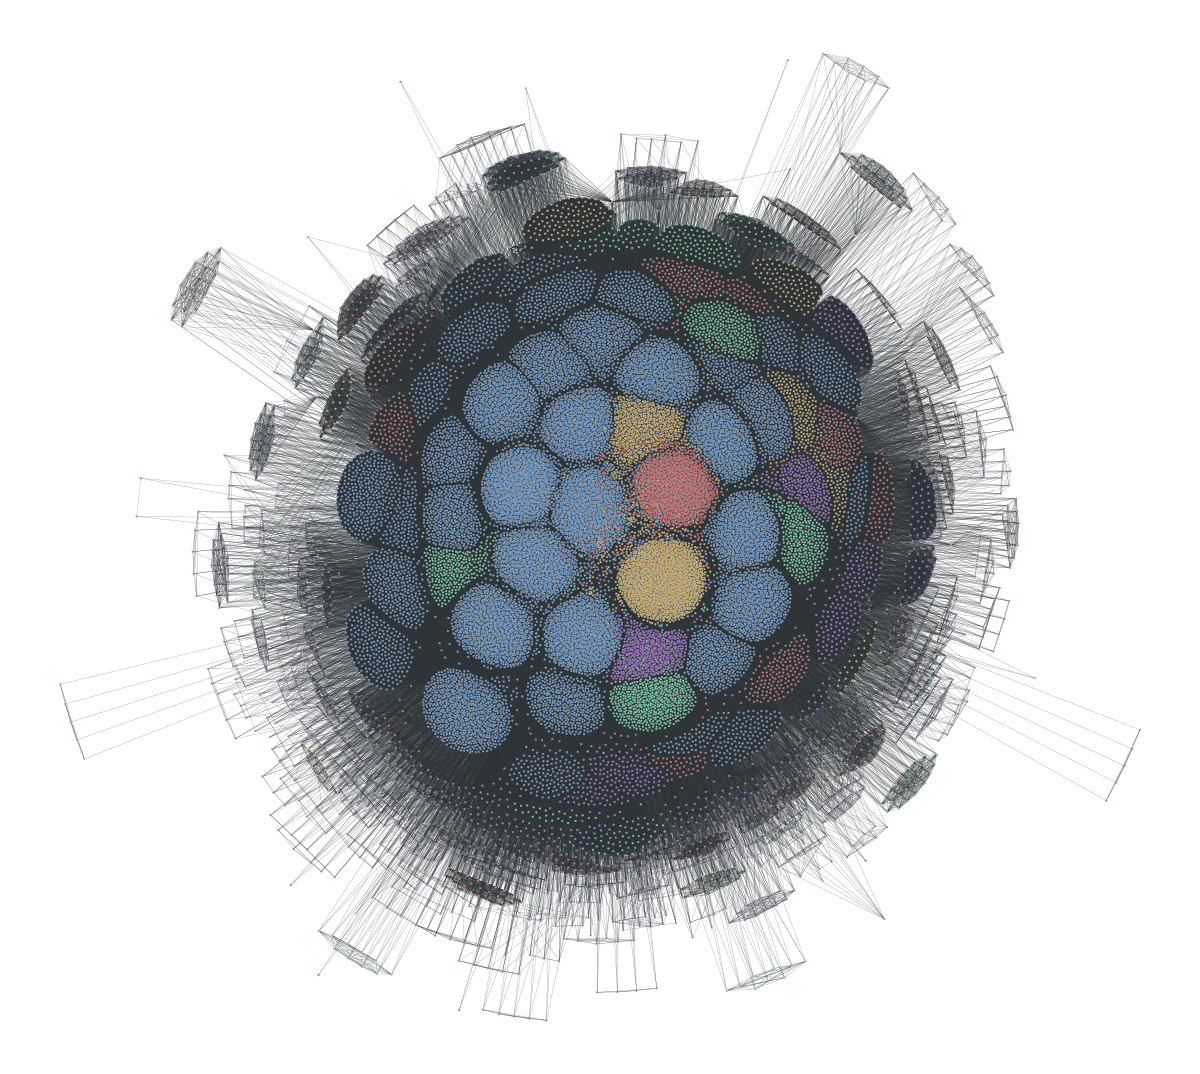

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdf1c2ff210, at 0x7fdf1c0c4fd0>

In [9]:
biggest_n_communities = 5

communities = Counter(property_map_communities)
biggest_communities = communities.most_common(biggest_n_communities)
print(f"Biggest communities: {biggest_communities}")

community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, biggest_n_communities):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == biggest_communities[i][0], True, False))
# print(f"len community_bool_filter: {len(community_bool_filter)}")
# print(f"community_bool_filter: {community_bool_filter[:10]}")
# print(f"property_map_communities: {property_map_communities[:10]}")

# print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

# print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
# print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

# color mapping for communities
color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7'}
# color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7', 5: '#cf720f', 6: '#72ca72', 7: '#cf7202', 8: '#72cf72', 9: '#0f720f'}
color_map_from_biggest_communities_indexes = {biggest_communities[i][0]: color_map[i] for i in range(biggest_n_communities)}

# print(f"color_map_from_biggest_communities_indexes {color_map_from_biggest_communities_indexes}")

vcolor = graph_community_analyzer.graph.new_vp("string") 

# print(f"vcolor type: {type(vcolor)}")
# print(f"filter_mask type: {type(filter_mask)}")

for v in graph_community_analyzer.graph.vertices():
    if graph_community_analyzer.graph.vertex_index[v] in np.where(community_bool_filter)[0]:
        vcolor[v] = color_map_from_biggest_communities_indexes[property_map_communities[graph_community_analyzer.graph.vertex_index[v]]]

# fill all vcolor values with black if not in filter_mask
for v in graph_community_analyzer.graph.vertices():
    if vcolor[v] == "":
        vcolor[v] = '#000000'

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=vcolor)






## Visualize smallest N communities

Smallest communities: [(np.int32(24418), 1), (np.int32(24487), 8), (np.int32(24118), 8), (np.int32(65277), 9), (np.int32(13694), 9), (np.int32(17078), 9), (np.int32(20699), 10), (np.int32(73769), 10)]


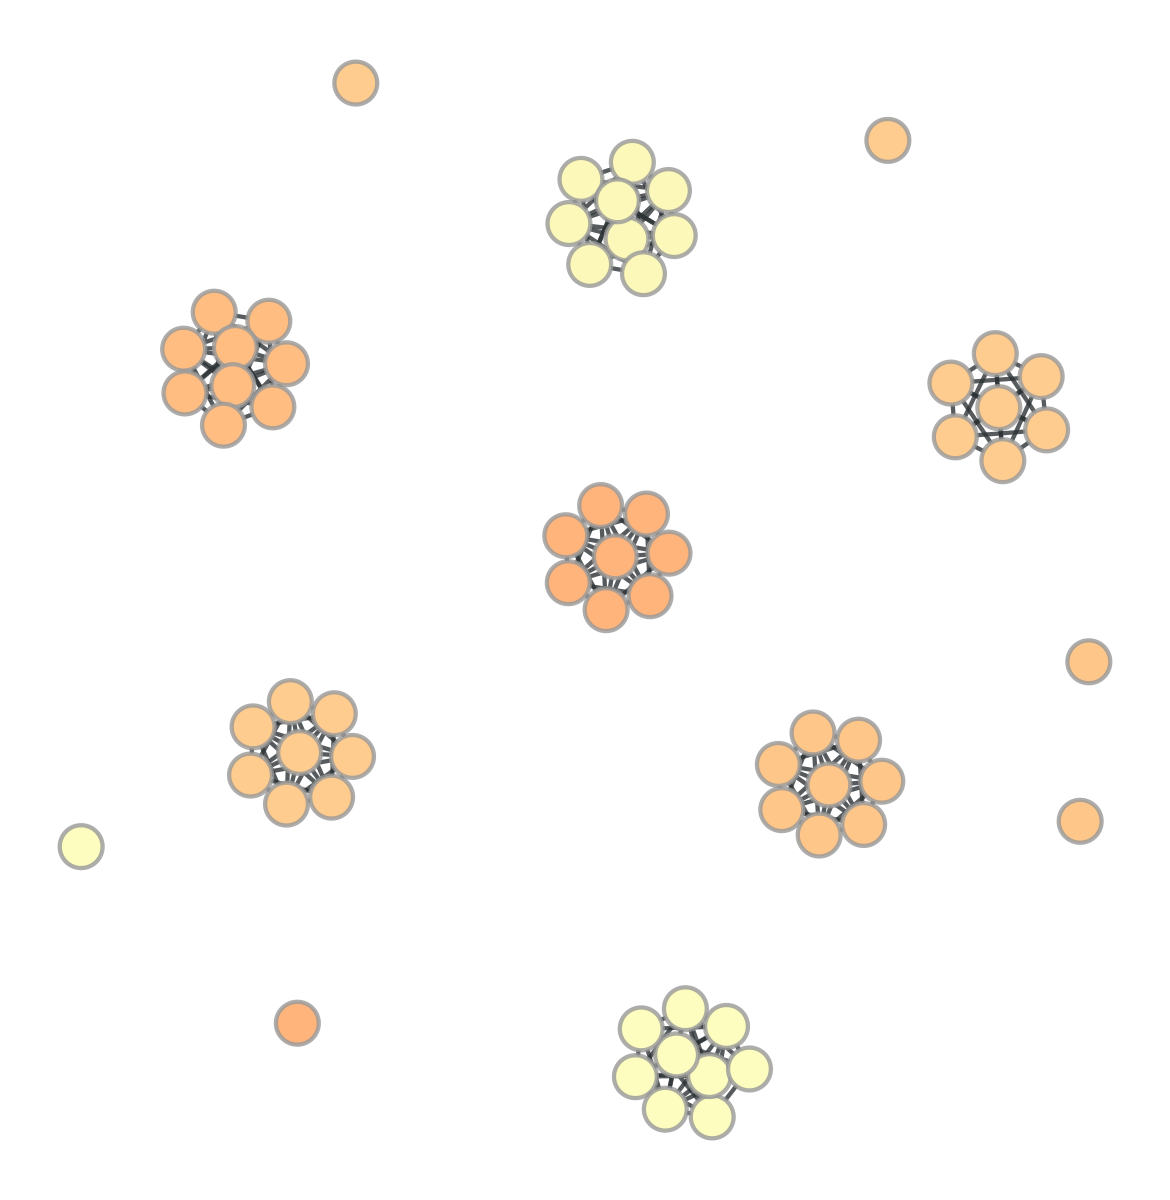

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdf1c14ca10, at 0x7fdf1c25a390>

In [10]:
n_smallest_communities = 8

smallest_communities = communities.most_common()[:-(n_smallest_communities+1):-1]
print(f"Smallest communities: {smallest_communities}")

community_bool_filter = np.where(property_map_communities == smallest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, n_smallest_communities):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == smallest_communities[i][0], True, False))
# print(f"len community_bool_filter: {len(community_bool_filter)}")
# print(f"community_bool_filter: {community_bool_filter[:10]}")
# print(f"property_map_communities: {property_map_communities[:10]}")

# print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

# print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
# print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=prop_to_size(graph_community_analyzer.communities['communities_modularity'], 0,1, power=.1))


## Get statistics of communities

### Init DB to query contributor information

In [11]:
from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db
from datetime import datetime

db_category_names = ['Amiga CD32 games', 'Machine learning', 'Game Boy games', 'Artificial intelligence']

category_name  = db_category_names[1]
db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)

Database initialized: wikipedia.db


In [12]:
def get_edit_stats_for_category(graph_community_analyzer, category_name):
    main_category_id = db_manager.get_main_category_by_name(category_name)

    # get all vertex properties
    vertex_properties = graph_community_analyzer.graph.vertex_properties
    #get id property
    id_property = vertex_properties['id']

    # construct a dict with the community as key and the nodes, stats as values
    community_stats = {'max': {}, 'min': {}, 'avg': {}, 'total': {}}
    community_nodes = {}
    community_nodes_nb_edits = {}
    nodes_oldest_edit = {}
    nodes_newest_edit = {}
    community_oldest_edit = {}
    community_newest_edit = {}

    for v in graph_community_analyzer.graph.vertices():
        community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]
        if community not in community_nodes:
            community_nodes[community] = []
            community_nodes_nb_edits[community] = []
        community_nodes[community].append(v)
        community_nodes_nb_edits[community].append(db_manager.get_number_of_revisions_per_contributor(id_property[v], main_category_id))
        node_edit_dates = db_manager.get_oldest_and_newest_revision_per_contributor_and_main_category(id_property[v], main_category_id)

        # print(f"type of node_edit_dates: {type(node_edit_dates)}")
        # print(f"node_edit_dates oldest: {type(node_edit_dates['oldest_revision'])}")
        # print(f"node_edit_dates: {node_edit_dates}")


        #parse date string as datetime
        if node_edit_dates['oldest_revision'] is not None:
            node_edit_dates['oldest_revision'] = datetime.strptime(node_edit_dates['oldest_revision'], '%Y-%m-%dT%H:%M:%SZ')
            nodes_oldest_edit[int(v)] = node_edit_dates['oldest_revision']
            if community not in community_oldest_edit:
                community_oldest_edit[community] = node_edit_dates['oldest_revision']
            if community_oldest_edit[community] > node_edit_dates['oldest_revision']:
                community_oldest_edit[community] = node_edit_dates['oldest_revision']
        
        if node_edit_dates['newest_revision'] is not None:
            node_edit_dates['newest_revision'] = datetime.strptime(node_edit_dates['newest_revision'], '%Y-%m-%dT%H:%M:%SZ')
            nodes_newest_edit[int(v)] = node_edit_dates['newest_revision']
            if community not in community_newest_edit:
                community_newest_edit[community] = node_edit_dates['newest_revision']
            if community_newest_edit[community] < node_edit_dates['newest_revision']:
                community_newest_edit[community] = node_edit_dates['newest_revision']

    for community in community_nodes_nb_edits.keys():
        community_stats['max'][community] = np.max(community_nodes_nb_edits[community])
        community_stats['min'][community] = np.min(community_nodes_nb_edits[community])
        community_stats['avg'][community] = np.mean(community_nodes_nb_edits[community])
        community_stats['total'][community] = np.sum(community_nodes_nb_edits[community])

    print(f"community_nodes: {community_nodes}")
    print(f"len community_nodes: {len(community_nodes.keys())}")

    #Total number of edits in category
    print(f"Total number of edits in category {category_name}: {db_manager.get_total_number_of_revisions_per_main_category(main_category_id)}")
    #Average number of edits per contributor
    print(f"Average edits of category {category_name}: {np.mean([np.mean(community_nodes_nb_edits[community]) for community in community_nodes_nb_edits.keys()])}")

    return community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit

community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit = get_edit_stats_for_category(graph_community_analyzer, category_name)


community_nodes: {np.int32(14130): [<Vertex object with index '0' at 0x7fdf8ef14840>, <Vertex object with index '1' at 0x7fdf1c87aa40>, <Vertex object with index '34' at 0x7fdf0fd46940>, <Vertex object with index '35' at 0x7fdf0fd46740>, <Vertex object with index '66' at 0x7fdf0fd472c0>, <Vertex object with index '67' at 0x7fdf0faf0040>, <Vertex object with index '93' at 0x7fdf0faf1ec0>, <Vertex object with index '102' at 0x7fdf0faf2140>, <Vertex object with index '139' at 0x7fdf0faf35c0>, <Vertex object with index '142' at 0x7fdf0faf3840>, <Vertex object with index '148' at 0x7fdf0faf3b40>, <Vertex object with index '161' at 0x7fdf0faf0440>, <Vertex object with index '164' at 0x7fdf0fb004c0>, <Vertex object with index '177' at 0x7fdf0fb00b40>, <Vertex object with index '192' at 0x7fdf0fb012c0>, <Vertex object with index '193' at 0x7fdf0fb01340>, <Vertex object with index '194' at 0x7fdf0fb013c0>, <Vertex object with index '202' at 0x7fdf0fb014c0>, <Vertex object with index '204' at 0x

/tmp/ipykernel_2492/2686729220.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


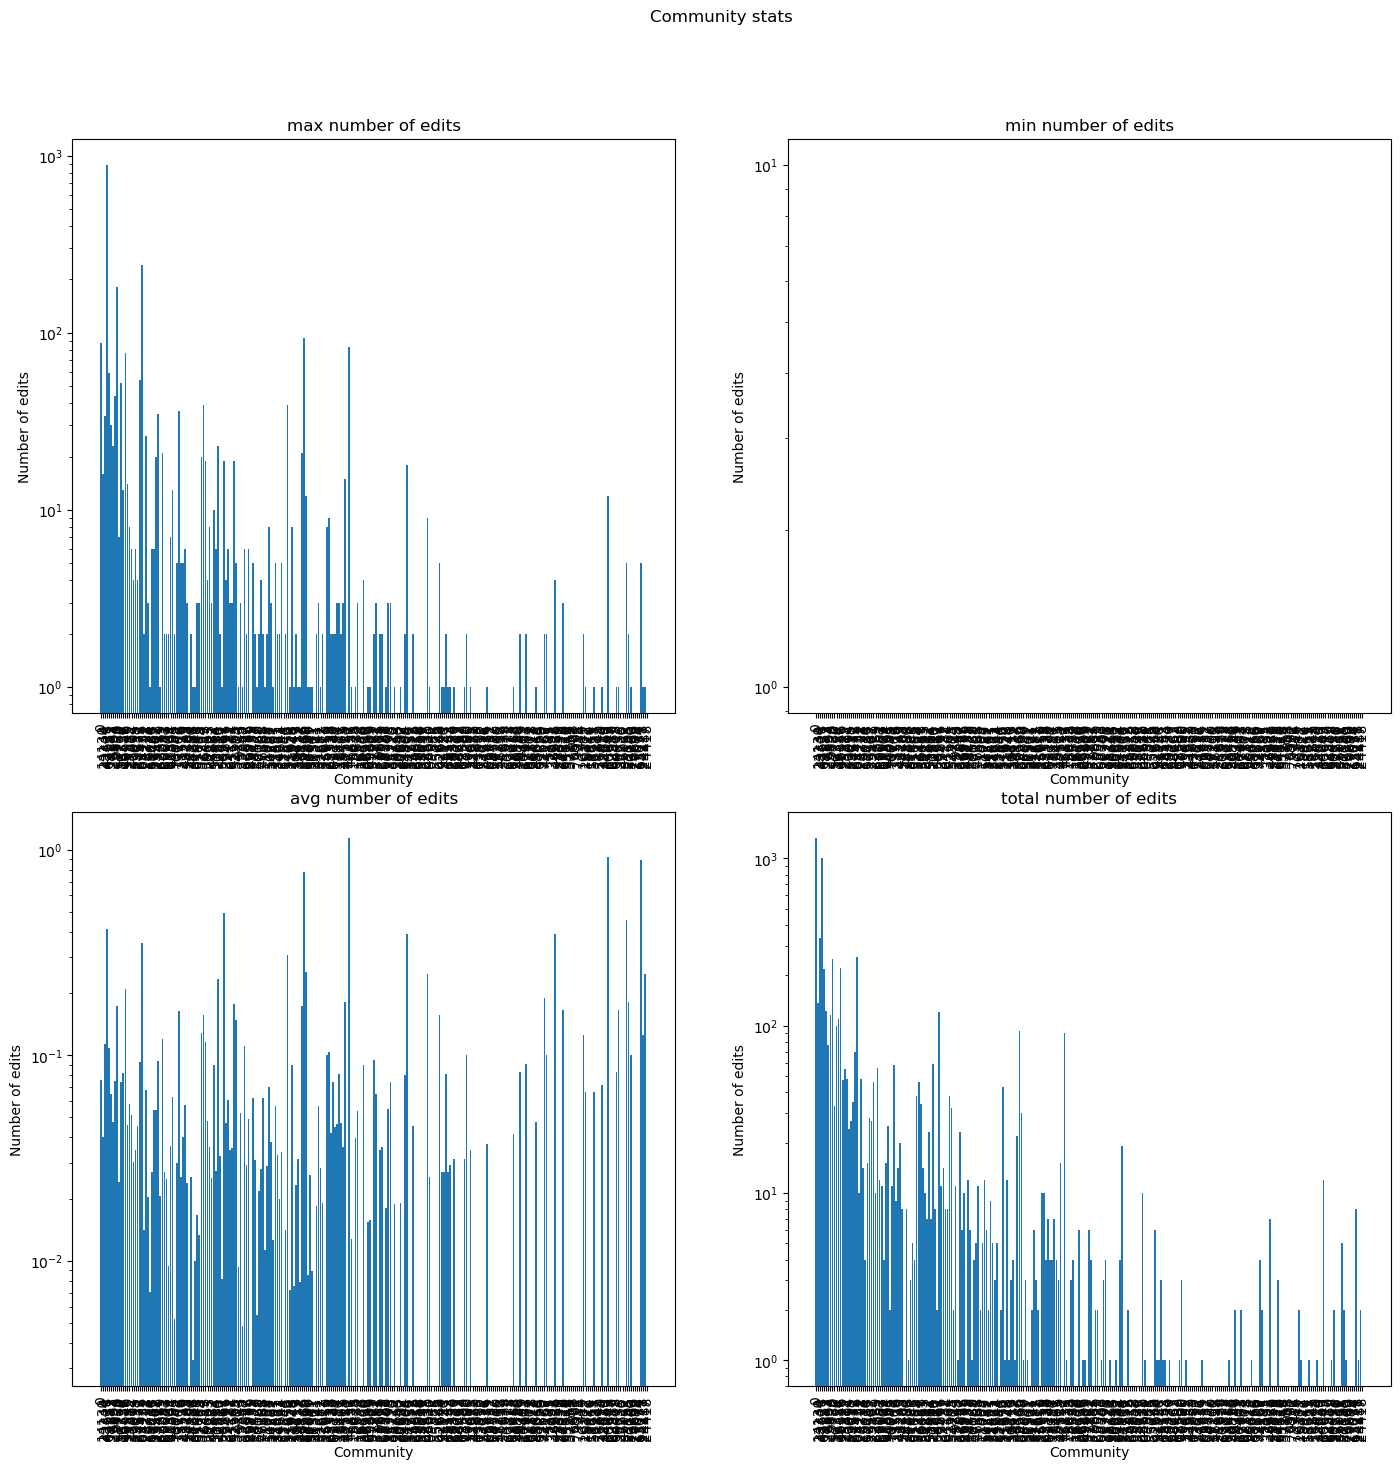

In [13]:
#plot distribution of stats over communities

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Community stats')
fig.tight_layout(pad=5.0)

for i, stat in enumerate(community_stats.keys()):
    ax = axs[i//2, i%2]

    # sort the community stats according to the order of the sorted_list_of_community_ids_by_size list
    sorted_community_stats = {community: community_stats[stat][community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_community_stats.keys()]
    x = np.arange(len(sorted_community_stats.keys()))
    y = list(sorted_community_stats.values())
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_yscale('log')
    ax.set_title(f'{stat} number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel('Community')
    
plt.show()

168 168 168


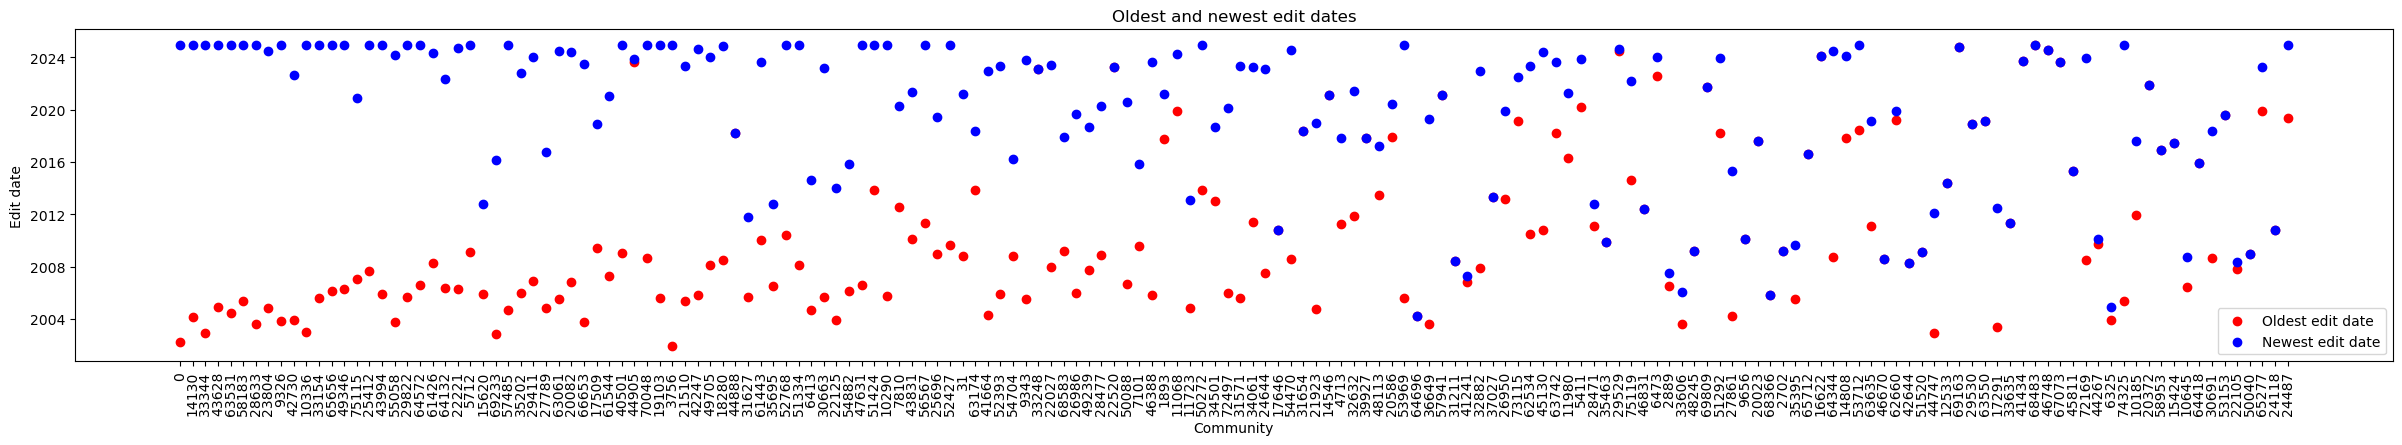

In [22]:
# plot oldest and newest edit dates as scatter plot with the oldest and newest edit dates as different colors for each community in the y-axis

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
fig.tight_layout(pad=5.0)

# sort the community stats according to the order of the sorted_list_of_community_ids_by_size list
sorted_oldest_edit = {}
sorted_newest_edit = {}

for community in sorted_list_of_community_ids_by_size:
    if community in community_oldest_edit and community in community_newest_edit:
        sorted_oldest_edit[community] = community_oldest_edit[community]

for community in sorted_list_of_community_ids_by_size:
    if community in sorted_oldest_edit and community in community_newest_edit:
        sorted_newest_edit[community] = community_newest_edit[community]

# sorted_oldest_edit = {community: community_oldest_edit[community] for community in sorted_list_of_community_ids_by_size}
# sorted_newest_edit = {community: community_newest_edit[community] for community in sorted_list_of_community_ids_by_size}

x = np.arange(len(sorted_oldest_edit.keys()))
x_label_strings = [f'{community}' for community in sorted_oldest_edit.keys()]
y1 = sorted_oldest_edit.values()
y2 = sorted_newest_edit.values()
print(len(x), len(y1), len(y2))

# print(type(list(y1)[0]))

# print(x)
# print(y1)
# print(y2)
ax.scatter(x, y1, color='r', label='Oldest edit date')
ax.scatter(x, y2, color='b', label='Newest edit date')
ax.set_xticks(x)
ax.set_xticklabels(x_label_strings, rotation=90)
ax.set_title('Oldest and newest edit dates')
ax.set_ylabel('Edit date')
ax.set_xlabel('Community')
ax.legend()

plt.show()

### Timeline of edits in a community

In [25]:
property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()

community_counts = Counter(property_map_communities)

sorted_list_of_community_ids_by_size = sorted(community_counts, key=community_counts.get, reverse=True)

first_id = sorted_list_of_community_ids_by_size[0]
last_id = sorted_list_of_community_ids_by_size[-1]

nodes_in_community_first = get_node_ids_from_community(graph_comm, graph_community_analyzer.communities['communities_modularity'], first_id)
nodes_in_community_last = get_node_ids_from_community(graph_comm, graph_community_analyzer.communities['communities_modularity'], last_id)

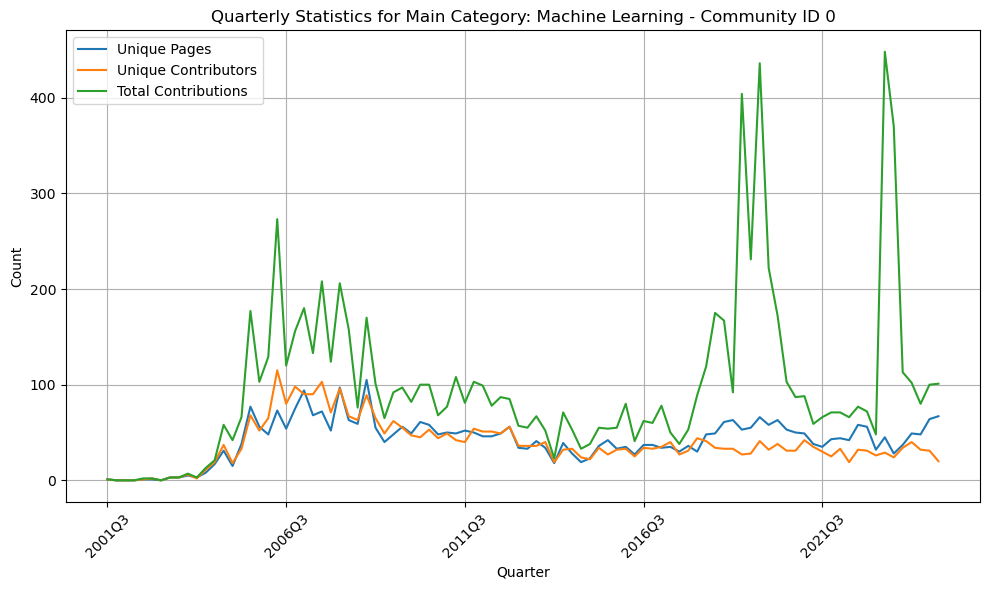

KeyError: 'month'

In [27]:

df = db_manager.get_unique_stats_per_month(1 , contributor_ids=nodes_in_community_first)
plot_stats_for_category_quarterly(df, f'Machine Learning - Community ID {first_id}')

df = db_manager.get_unique_stats_per_month(1 , contributor_ids=nodes_in_community_last)
plot_stats_for_category_quarterly(df, f'Machine Learning - Community ID {last_id}')

## Analyze graph properties and plot them per community

In [28]:
centrality_analyzer = CentralityAnalyzer(graph_community_analyzer.graph)
centrality_analyzer.calculate_centralities()

closn = centrality_analyzer.get_closeness_centrality()
eigenv = centrality_analyzer.get_eigenvector_centrality()
betweenness = centrality_analyzer.get_betweenness_centrality()
degrees = centrality_analyzer.get_degrees()




Calculating degrees...
Degrees calculated in 0.01 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 3.41 seconds.

Calculating closeness...
Closeness centrality calculated in 6488.02 seconds.

Calculating betweenness...
Betweenness centrality calculated in 7707.34 seconds.



In [29]:
#serialize the  closn, eigenv, betweenness, degrees to files
import pickle

with open('outputs/graphs/ML_closn.pkl', 'wb') as f:
    pickle.dump(closn, f)

with open('outputs/graphs/ML_eigenv.pkl', 'wb') as f:
    pickle.dump(eigenv, f)

with open('outputs/graphs/ML_betweenness.pkl', 'wb') as f:
    pickle.dump(betweenness, f)

with open('outputs/graphs/ML_degrees.pkl', 'wb') as f:
    pickle.dump(degrees, f)


In [30]:
community_closeness = {}
community_eigenvector = {}
community_betweenness = {}
community_degrees = {}

# get closeness centrality for each community
for v in graph_community_analyzer.graph.vertices():
    community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]

    if community not in community_closeness:
        community_closeness[community] = []
    community_closeness[community].append(closn[graph_community_analyzer.graph.vertex_index[v]])

    # get eigenvector centrality for each community
    if community not in community_eigenvector:
        community_eigenvector[community] = []
    community_eigenvector[community].append(eigenv[graph_community_analyzer.graph.vertex_index[v]])

    # get betweenness centrality for each community
    if community not in community_betweenness:
        community_betweenness[community] = []
    community_betweenness[community].append(betweenness[graph_community_analyzer.graph.vertex_index[v]])

    # get degrees for each community
    if community not in community_degrees:
        community_degrees[community] = []
    community_degrees[community].append(degrees[graph_community_analyzer.graph.vertex_index[v]])


### Get usernames of high centrality nodes

In [39]:
top_N_centrality_nodes = 20

top_closeness_nodes = np.flip(np.argsort(closn)[-top_N_centrality_nodes:])
top_eigenvector_nodes = np.flip(np.argsort(eigenv)[-top_N_centrality_nodes:])
top_betweenness_nodes = np.flip(np.argsort(betweenness)[-top_N_centrality_nodes:])
top_degree_nodes = np.flip(np.argsort(degrees)[-top_N_centrality_nodes:])

top_closeness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_closeness_nodes]
top_eigenvector_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_eigenvector_nodes]
top_betweenness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_betweenness_nodes]
top_degree_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_degree_nodes]

top_closeness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_closeness_nodes_ids]
top_eigenvector_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_eigenvector_nodes_ids]
top_betweenness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_betweenness_nodes_ids]
top_degree_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_degree_nodes_ids]
 
print("------------ Closeness ---------------")
for i in range(len(top_closeness_nodes)):
    print(f"{closn[top_closeness_nodes[i]]:.4f} &\t {top_closeness_nodes_usernames[i]} & \\\\")

print("------------ Eigenvector ---------------")
for i in range(len(top_eigenvector_nodes)):
    print(f"{eigenv[top_eigenvector_nodes[i]]:.4f} &\t {top_eigenvector_nodes_usernames[i]} & \\\\")

print("------------ Betweenness ---------------")
for i in range(len(top_betweenness_nodes)):
    print(f"{betweenness[top_betweenness_nodes[i]]:.4f} &\t {top_betweenness_nodes_usernames[i]} & \\\\")

print("------------ Degree ---------------")
for i in range(len(top_degree_nodes)):
    print(f"{degrees[top_degree_nodes[i]]} &\t {top_degree_nodes_usernames[i]} & \\\\")



------------ Closeness ---------------
0.9564598168870804 &	 HollywoodHero30 & \\
0.8701124427374948 &	 StraightDown & \\
0.8487187299008158 &	 Neils51 & \\
0.8279232572730575 &	 109.186.81.131 & \\
0.8133657745336578 &	 77.172.84.170 & \\
0.7625767990753696 &	 G026r & \\
0.7508160392896716 &	 109.100.39.197 & \\
0.7505388361139937 &	 128.100.123.155 & \\
0.7448603683897801 &	 82.41.232.96 & \\
0.7446538888008871 &	 78.190.181.103 & \\
0.7369854691893905 &	 SpecB & \\
0.7236830711502382 &	 217.46.147.13 & \\
0.7147567778168444 &	 Tassedethe & \\
0.7070967256728682 &	 148.75.188.99 & \\
0.7055380459252589 &	 MindWraith & \\
0.6985270900276751 &	 Grondilu & \\
0.6956264392797359 &	 Technoarg & \\
0.6946820104549569 &	 76.181.78.25 & \\
0.6865843305857546 &	 2605:E000:131A:415B:F84E:FD1F:5CDF:59BC & \\
0.6862836339747626 &	 2603:8001:8403:7188:D57C:6EE8:B0BB:847 & \\
------------ Eigenvector ---------------
0.06235616518009735 &	 HollywoodHero30 & \\
0.061151610319186527 &	 StraightDown &

### Get usernames of low centrality nodes

In [42]:
bottom_N_centrality_nodes = 20


bottom_closeness_nodes = np.argsort(closn)[:bottom_N_centrality_nodes]
bottom_eigenvector_nodes = np.argsort(eigenv)[:bottom_N_centrality_nodes]
bottom_betweenness_nodes = np.argsort(betweenness)[:bottom_N_centrality_nodes]
bottom_degree_nodes = np.argsort(degrees)[:bottom_N_centrality_nodes]

bottom_closeness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_closeness_nodes]
bottom_eigenvector_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_eigenvector_nodes]
bottom_betweenness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_betweenness_nodes]
bottom_degree_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_degree_nodes]

bottom_closeness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_closeness_nodes_ids]
bottom_eigenvector_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_eigenvector_nodes_ids]
bottom_betweenness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_betweenness_nodes_ids]
bottom_degree_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_degree_nodes_ids]

print("------------ Closeness ---------------")
for i in range(len(bottom_closeness_nodes)):
    print(f"{closn[bottom_closeness_nodes[i]]:.4f} &\t {bottom_closeness_nodes_usernames[i]} &  \\\\")

print("------------ Eigenvector ---------------")
for i in range(len(bottom_eigenvector_nodes)):
    print(f"{eigenv[bottom_eigenvector_nodes[i]]:.4f} &\t {bottom_eigenvector_nodes_usernames[i]} &  \\\\")

print("------------ Betweenness ---------------")
for i in range(len(bottom_betweenness_nodes)):
    print(f"{betweenness[bottom_betweenness_nodes[i]]:.4f} &\t {bottom_betweenness_nodes_usernames[i]} &  \\\\")

print("------------ Degree ---------------")
for i in range(len(bottom_degree_nodes)):
    print(f"{degrees[bottom_degree_nodes[i]]} &\t {bottom_degree_nodes_usernames[i]} &  \\\\")


------------ Closeness ---------------
0.3387 &	 112.196.159.98 &  \\
0.3387 &	 128.135.98.204 &  \\
0.3561 &	 SeanBob123 &  \\
0.3615 &	 150.212.127.29 &  \\
0.3629 &	 195.33.34.80 &  \\
0.3629 &	 Oldmaven &  \\
0.3629 &	 68.109.20.220 &  \\
0.3661 &	 Workmonk &  \\
0.3661 &	 81.234.233.203 &  \\
0.3661 &	 165.225.102.50 &  \\
0.3661 &	 Krelnik &  \\
0.3661 &	 68.145.164.127 &  \\
0.3661 &	 198.2.76.28 &  \\
0.3661 &	 Perl coder &  \\
0.3661 &	 Leighpankonien &  \\
0.3684 &	 84.18.150.170 &  \\
0.3709 &	 Colin a jones &  \\
0.3725 &	 64.128.174.217 &  \\
0.3725 &	 Sh mahdi &  \\
0.3725 &	 108.178.177.210 &  \\
------------ Eigenvector ---------------
0.0000 &	 128.135.98.204 &  \\
0.0000 &	 112.196.159.98 &  \\
0.0000 &	 SeanBob123 &  \\
0.0000 &	 84.18.150.170 &  \\
0.0000 &	 150.212.127.29 &  \\
0.0000 &	 Oldmaven &  \\
0.0000 &	 68.109.20.220 &  \\
0.0000 &	 195.33.34.80 &  \\
0.0000 &	 Workmonk &  \\
0.0000 &	 Perl coder &  \\
0.0000 &	 68.145.164.127 &  \\
0.0000 &	 Leighpankonie

### Plot distributions of mean centrality measures per community

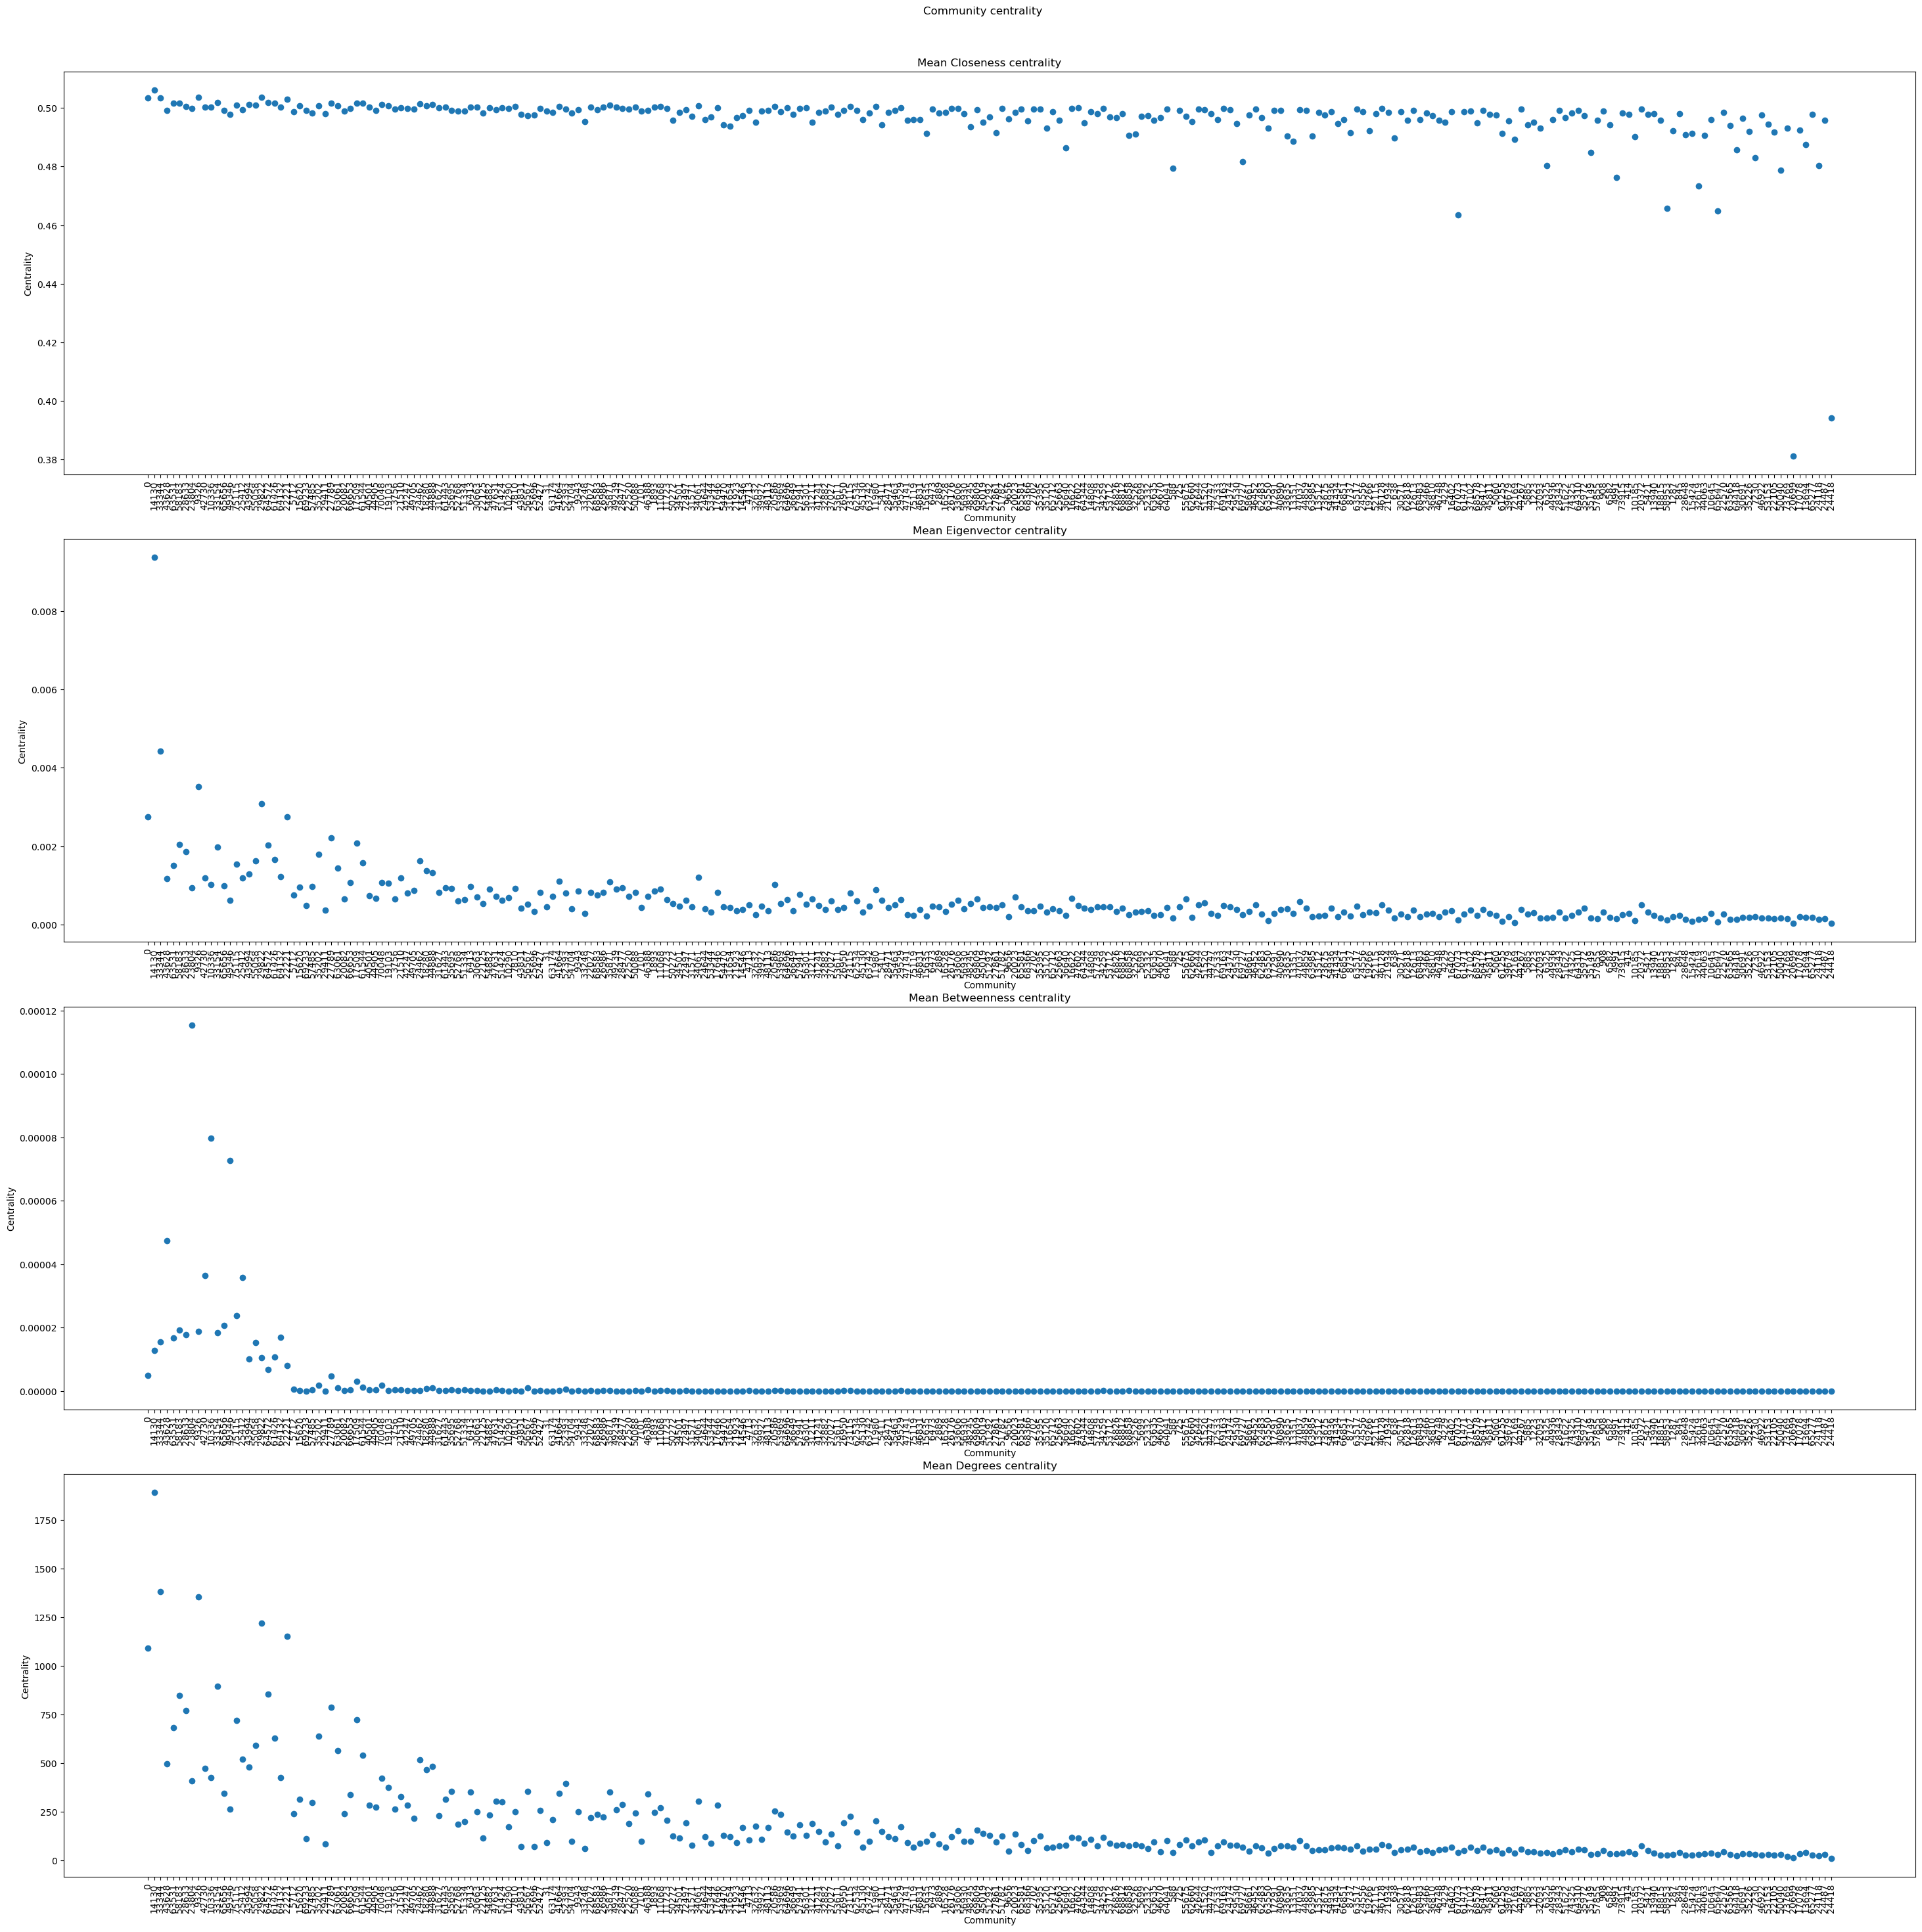

In [38]:
#plot distribution of closeness and eigenvector centrality over communities

fig, axs = plt.subplots(4, 1, figsize=(30, 30))
fig.suptitle('Community centrality')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector, community_betweenness, community_degrees]):
    ax = axs[i]
    if i == 0:
        chart_title = 'Closeness'
    elif i == 1:
        chart_title = 'Eigenvector'
    elif i == 2:
        chart_title = 'Betweenness'
    else:
        chart_title = 'Degrees'

    sorted_centrality = {community: centrality[community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_centrality.keys()]
    x = np.arange(len(sorted_centrality.keys()))
    y = [np.mean(sorted_centrality[community]) for community in sorted_centrality.keys()]
    ax.scatter(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_title(f'Mean {chart_title} centrality')
    ax.set_ylabel('Centrality')
    ax.set_xlabel('Community')

plt.show()


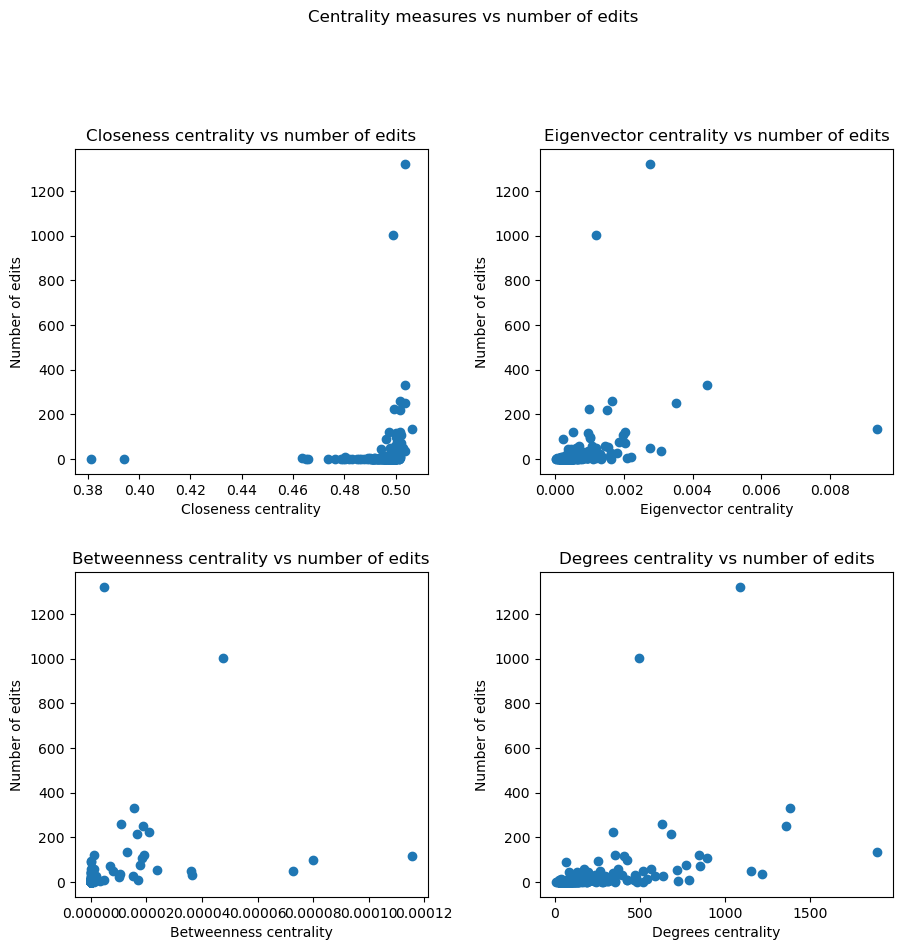

In [34]:
# plot centrality measures against number of edits for each community

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Centrality measures vs number of edits')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector]):
    ax = axs[0][i]
    chart_title = 'Closeness' if i == 0 else 'Eigenvector'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    labels = [f'{community}' for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')

for i, centrality in enumerate([community_betweenness, community_degrees]):
    ax = axs[1][i]
    chart_title = 'Betweenness' if i == 0 else 'Degrees'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')